In [1]:
from orix.crystal_map.utilities import spatial_decomposition
import shapely
import numpy as np

In [2]:
#[V,F,I_FD] = spatialDecomposition([ebsd.prop.x(:), ebsd.prop.y(:)],ebsd.unitCell,varargin{:});
import numpy as np
from orix.crystal_map.utilities import spatial_decomposition
X = np.loadtxt('../spatial_decomposition_test_folder/spatialDecomposition_input_X.csv', delimiter=',', dtype=float)
uc = np.loadtxt('../spatial_decomposition_test_folder/calcUnitCell_output_unitCell.csv', delimiter=',', dtype=float)
V, F, I_FD = spatial_decomposition(X, unit_cell=uc)

FileNotFoundError: ../spatial_decomposition_test_folder/spatialDecomposition_input_X.csv not found.

/Users/paytone/Documents/GitHub/Mart2Aust_Hackathon/orix/io/plugins/ang.py:358: UserWarning: Symmetry is interpreted as a point group, but input value is greater than 32. Input symmetry m converted to space group 43
  warnings.warn(


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

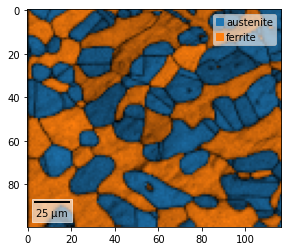

In [3]:
from orix import data, io, plot
ebsd = data.sdss_ferrite_austenite(allow_download=True)
ebsd.plot(overlay="dp")
uc = np.loadtxt('../spatial_decomposition_test_folder/calcUnitCell_output_unitCell.csv', delimiter=',', dtype=float)

X = np.array([ebsd.x, ebsd.y]).T
V, F, I_FD = spatial_decomposition(X, unit_cell=uc)



In [4]:
from orix.quaternion import Orientation
from orix.quaternion import symmetry

def gbc_angle(q1, s1, Dl, Dr, threshold):
     # still needs **kwargs to enable two misorientation angle choices like MTEX
     qs = Orientation(q1,s1)
     qs = qs.map_into_symmetry_reduced_zone


     o1 = qs[Dl]
     o2 = qs[Dr]

     mis = o1*~o2 #angle(orientation(q(Dl),CS),orientation(q(Dr),CS))

     #print(d.angle) 
     # if np.ndarray.size(threshold) == 1:
     criterion = mis.angle < threshold

     return criterion




In [5]:
# g = networkx(A)
# 

#if you want to do grain segmentation, get the adjacency matrix from spatial decomp like this:

A = F_ID.dot(F_ID.T)

#Then, compare every entry in the matrix, and cut the connections above the grain boundary cuttoff threshold (lots of ways to do this) to get A_in_grain. Then make a graph like this

G = nx.from_scipy_sparse_array(A)
#then cluster like this:
feature_clusters = list(nx.connected_components(G))

#Here is an alternate way to do this that does not require spatial decomp, but only works for square and hex grids, not random ones or ones with significant missing data.


#def connectedComponents(A)
# label connected componentes in an graph (adjacency matrix)

# elimination tree
#parent = etree(A);

#isleaf = parent ~= 0;
#parent(~isleaf) = 1:nnz(~isleaf);
#i = find(isleaf);
#for i = i(end:-1:1)
#  parent(i) = parent(parent(i));
#end

NameError: name 'F_ID' is not defined

In [6]:
orix.quaternion.Orientation.identity

NameError: name 'orix' is not defined

In [7]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Author: Tyler Martin and Eric Payton
Github: martint98 and paytonej
Date: 5/16/2022, 7/15/2022, and 8/8/2022
"""

gbc_value = 10.

import numpy as np
from scipy.sparse import coo_matrix, triu, find
#import markov_clustering as mc
#import networkx as nx
import matplotlib.pyplot as plt
from orix.crystal_map.utilities import gbc_angle

def do_segmentation(I_FD, ebsd, gbc_value=5., maxDist=0):
    # Output
    # A_Db - adjacency matrix of grain boundaries
    # A_Do - adjacency matrix inside grain connections

    # convert gbc value to radians
    threshold = gbc_value * np.pi / 180.0

    ## if numel(gbcValue) == 1 && length(ebsd.CSList) > 1
    phase_ids = np.unique(ebsd.phase_id)
    if np.size(gbc_value) == 1 and len(phase_ids) > 1:
        ##   gbcValue = repmat(gbcValue,size(ebsd.CSList))
        threshold = np.repeat(threshold, np.shape(phase_ids))

    # get pairs of neighbouring cells {D_l,D_r} in A_D
    A_D = I_FD.T * I_FD == 1

    ## [Dl,Dr] = find(triu(A_D,1))
    Dl, Dr, _  = find(triu(A_D, k=1))          # Get upper triangular part of matrix

    connect = np.zeros(np.shape(Dl), dtype=bool)

    ## for p = 1:numel(ebsd.phaseMap)
    for p in phase_ids:

        ndx = np.all(np.vstack([ebsd.phase_id[Dl] == p, ebsd.phase_id[Dl] == p]), axis=0)

        connect[ndx] = True        

        # check whether they are indexed
        ndx = np.all([ndx, ebsd.is_indexed[Dl], ebsd.is_indexed[Dr]])                            # returns index if all true

        # now check for the grain boundary criterion
        if np.any(ndx):

            connect[ndx] = gbc_angle(ebsd.rotations, ebsd.phases.point_groups[p-1], Dl[ndx], Dr[ndx], threshold)

    # adjacency of pixels that are in different grains
    A_Do = csr_matrix((np.ones(np.shape(Dl[connect])), (Dl[connect], Dr[connect])), shape=(ebsd.size, ebsd.size))
    rows, cols = A_Do.nonzero()
    A_Do[cols, rows] = A_Do[rows, cols] # Make symmetric

    # adjacency of pixels that are in the same grains
    mask = np.ones(connect.shape, dtype=bool)
    mask[connect] = False
    A_Db = coo_matrix((np.ones(np.shape(Dl[mask])), (Dl[mask], Dr[mask])), shape=(ebsd.size, ebsd.size));
    rows, cols = A_Db.nonzero()
    A_Db[cols, rows] = A_Db[rows, cols] # Make symmetric

    return A_Db, A_Do

In [20]:

from scipy.sparse import csr_matrix, coo_matrix, find
from scipy.sparse.csgraph import connected_components
import networkx as nx
from orix.crystal_map.utilities import spatial_decomposition

def calc_grains(ebsd):
    # subdivide the domain into cells according to the measurement locations,
    # i.e. by Voronoi teselation or unit cell
    V, F, I_FD = spatial_decomposition(np.array([ebsd.x, ebsd.y]).T)
    # V - list of vertices
    # F - list of faces
    # D - cell array of cells
    # I_FD - incidence matrix faces to vertices

    # determine which cells to connect
    A_Db, A_Do = do_segmentation(I_FD, ebsd)
    # A_Db - neighbouring cells with grain boundary
    # A_Do - neighbouring cells without grain boundary

    #then cluster like this:
    feature_clusters = connected_components(A_Do)
    feature_clusters = feature_clusters[1]

    # compute grains as connected components of A_Do
    ## I_DG - incidence matrix cells to grains
    # I_DG = coo_matrix((np.ones(len(feature_clusters), dtype=np.int32),
    #                  (np.arange(0,len(feature_clusters), dtype=np.int32), feature_clusters)), 
    #                  shape=(len(feature_clusters), max(feature_clusters)+1))

    # compute grain ids
    #grain_id = find(I_DG.T)

    #ebsd.prop.grain_id = feature_clusters
    ebsd.prop["grain_id"] = feature_clusters

    return ebsd

/Users/paytone/Documents/GitHub/Mart2Aust_Hackathon/orix/io/plugins/ang.py:358: UserWarning: Symmetry is interpreted as a point group, but input value is greater than 32. Input symmetry m converted to space group 43
  warnings.warn(
/Users/paytone/Documents/GitHub/Mart2Aust_Hackathon/orix/crystal_map/utilities.py:384: UserWarning: parameter a must be of integer type. Converting a into integers and moving on...
  warnings.warn('parameter ''a'' must be of integer type. Converting ''a'' into integers and moving on...')
/Users/paytone/anaconda3/envs/hackathon/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


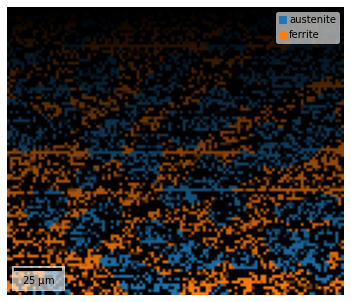

In [21]:
from orix import data, io, plot
ebsd = data.sdss_ferrite_austenite(allow_download=True)

fnom = u"/Users/paytone/Documents/GitHub/Mart2Aust_Hackathon/Data/steel_ebsd.ang"
#ebsd = io.loadang(
#ebsd.plot(overlay="dp")
uc = np.loadtxt('../spatial_decomposition_test_folder/calcUnitCell_output_unitCell.csv', delimiter=',', dtype=float)

ebsd = calc_grains(ebsd)

#ebsd.plot()

ebsd.plot(overlay='grain_id', remove_padding=True)

#X = np.array([ebsd.x, ebsd.y]).T
#V, F, I_FD = spatial_decomposition(X, unit_cell=uc)

In [ ]:
ebsd.prop

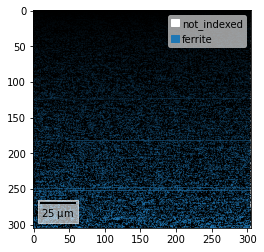

In [22]:

import numpy as np
import orix
import matplotlib.pyplot as plt
from diffpy.structure import Atom, Lattice, Structure

from orix import plot
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.io import load, save
from orix.quaternion import Orientation, Rotation, symmetry
from orix.vector import Vector3d

%matplotlib inline

dataPath = '/Users/paytone/Documents/GitHub/maxflow_for_matsci/Data/'
fileName = 'steel_ebsd.ang'
target = dataPath + fileName

euler1, euler2, euler3, x, y, iq, ci, phase_id, sem, fit = np.loadtxt(target, unpack=True)

euler_angles = np.column_stack((euler1, euler2, euler3))
rotations = Rotation.from_euler(euler_angles)
properties = dict(iq=iq, dp=ci)

# Create unit cells of the phases
structures = [
    Structure(
        title="ferrite",
        atoms=[Atom("fe", [0] * 3)],
        lattice=Lattice(0.287, 0.287, 0.287, 90, 90, 90)
    ),
]
phase_list = PhaseList(
    names=["ferrite"],
    point_groups=["4/mmm"],
    structures=structures,
)

# Create a CrystalMap instance
xmap2 = CrystalMap(
    rotations=rotations,
    phase_id=phase_id,
    x=x,
    y=y,
    phase_list=phase_list,
    prop=properties,
)
xmap2.scan_unit = "um"

xmap2 = calc_grains(xmap2)

xmap2.plot(overlay='grain_id')

In [23]:
xmap2.prop

{'iq': array([1598816.3, 2936437. , 3544651. , ..., 2686660. , 2430285.8,
              0. ]),
 'dp': array([0.486, 0.771, 0.714, ..., 0.086, 0.029, 0.   ]),
 'grain_id': array([    0,     0,     0, ..., 21192,     0, 21193], dtype=int32)}

In [17]:
xmap2.ndim

2

In [18]:
xmap2.shape

(305, 305)

In [19]:
305*305

93025